# Построение графиков

В настоящем ноутбуке приведён подробный пример обработки результатов работы `sparkling`

Для начала необходимо импортировать библиотеки для удобного считывания и обработки данных, а также библиотеку `pyplot`, необходимую для построения графиков

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import numpy as np

### Считывание из .json файла

Следующим шагом необходимо считать `.json` файл. В нашем примере файл называется `example-data.json` и лежит в той же папке, что и Jupyter Notebook. Для обработки вашего файла необходимо изменить переменные *FILENAME* и *PATH*, указав в них имя файла и путь к нему соответственно.

После выполнения кода ниже в переменной *data* будет лежать список словарей. Каждый элемент списка является словарем, который хранит информацию об одной итерации алгоритма выбора и настройки алгоритма кластеризации и его гиперпараметров. С точки зрения анализа работы алгоритмов кластеризации нас интересуют два поля словаря: достигнутое за время работы алгоритма значение меры качества (CVI) и использованный на текущей итерации алгоритм кластеризации. Их мы поместим в переменную *values*

In [16]:
FILENAME = 'example_sparkling_output.json'
PATH = './'

with open(PATH+FILENAME) as json_file:
        data = json.load(json_file)
        
values = [{'val': -d['value'], 'algo': d['algo']} for d in data]

### Приведение данных к удобному для построения формату, фильтрация

Для удобства первым шагом сформируем из списка словарей pandas dataframe.

В случае, если алгоритм кластеризации не смог найти разбиение на текущем шаге, в данных могут возникнуть значения метрик, равные бесконечности. Такое может происходить, если при рассматриваемых на текущей итерации параметрах алгоритма кластеризации разбиение не может быть найдено. В таких случаях считаем, что на текущей итерации значение метрики не изменилось.

Для этого все "плохие" значения метрик заменияем на *NaN*, после чего применяем метод *fillna*

In [17]:
df = pd.DataFrame(values)
df.replace(np.inf, np.nan, inplace=True)
df.replace(-np.inf, np.nan, inplace=True)
data = df.pivot(columns="algo", values='val')
algos = {col: data[col].fillna(method='ffill') for col in data.columns}

## Построение кумулятивного графика

Удобнее всего для анализа эффективности алгоритма кластеризации к конкретному набору данных использовать кумулятивный график. Мы будем строить для каждого алгоритма кумулятивный максимум, то есть по вертикальной оси откладывается не значение меры на текущей итерации, а наилучшее полученное значение меры качества.

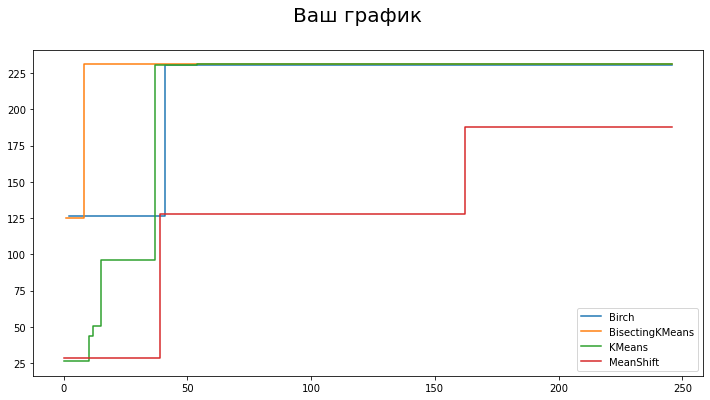

In [18]:
algos_cumulative = {key: algos[key].cummax() for key in algos.keys()}
    
fig = plt.figure(figsize=(12, 6))
for key in algos.keys():
    plt.step(list(range(len(algos_cumulative[key]))), algos_cumulative[key], label=key)
fig.suptitle(f'Ваш график', fontsize=20)
plt.legend()
plt.show()

## Построение некумулятивного графика

Если необходимо оценить стабильность выдачи алгоритма, то может быть полезно визуально оценить выдачу алгоритмов на каждой итерации.

Для этого можно построить не кумулятивный график.

При большом количестве итераций рекомендуется использовать [метод скользящей средней](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) для обобщения тренда.

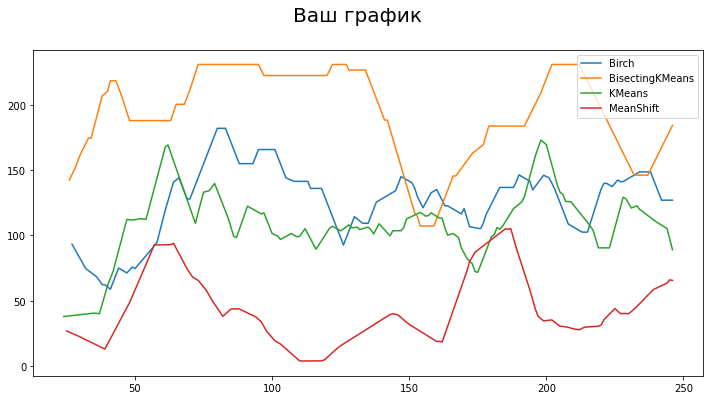

In [23]:
WINDOW = 25

fig = plt.figure(figsize=(12, 6))
for key in algos.keys():
    plt.plot(algos[key].rolling(window=WINDOW).mean(), label=key)
fig.suptitle(f'Ваш график', fontsize=20)
plt.legend()

plt.show()